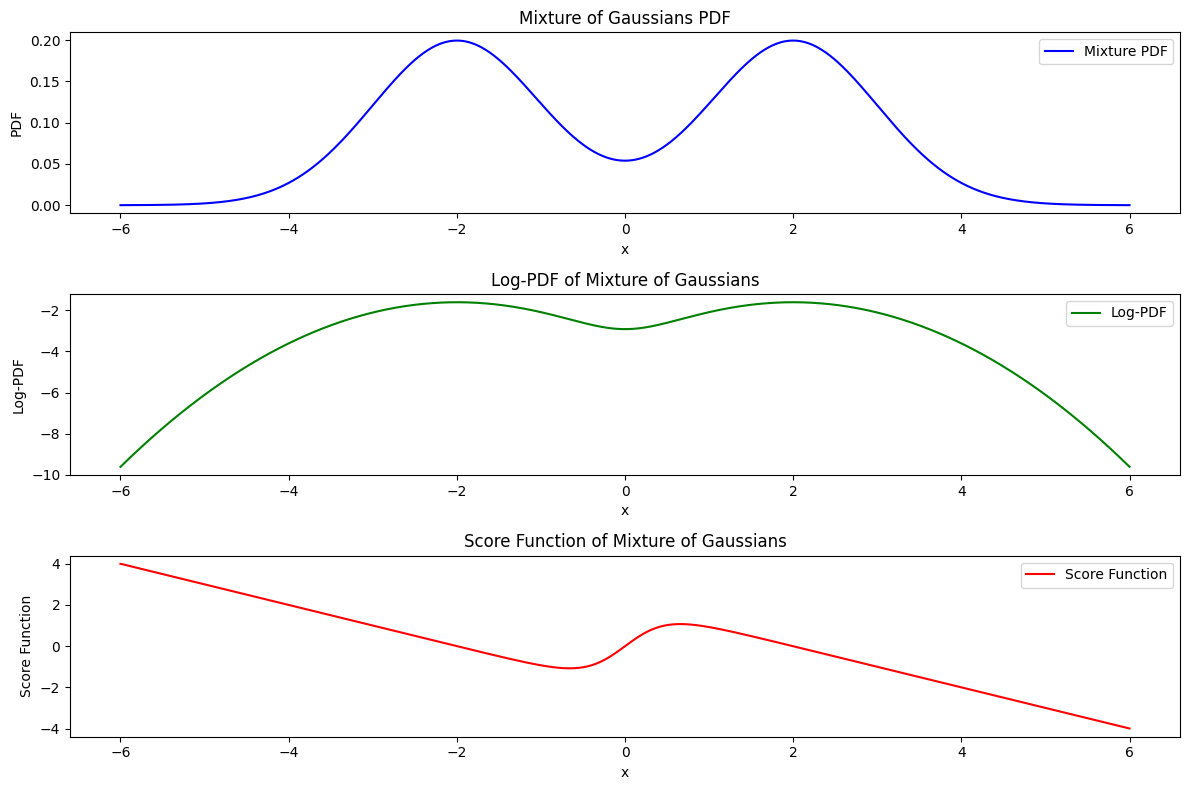

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the mixture of Gaussians
def mixture_pdf(x, means, stds, weights):
    """
    Compute the PDF of a mixture of Gaussians.
    """
    pdf = np.zeros_like(x)
    for mean, std, weight in zip(means, stds, weights):
        pdf += weight * norm.pdf(x, loc=mean, scale=std)
    return pdf

def mixture_log_pdf(x, means, stds, weights):
    """
    Compute the log-PDF of a mixture of Gaussians.
    """
    pdf = mixture_pdf(x, means, stds, weights)
    return np.log(pdf)

def mixture_score_function(x, means, stds, weights):
    """
    Compute the score function (gradient of log-PDF) of a mixture of Gaussians.
    """
    eps = 1e-8  # Small constant to avoid division by zero
    log_pdf = mixture_log_pdf(x, means, stds, weights)
    gradient = np.gradient(log_pdf, x)
    return gradient

# Parameters for the mixture of Gaussians
means = [-2, 2]  # Means of the Gaussians
stds = [1, 1]    # Standard deviations of the Gaussians
weights = [0.5, 0.5]  # Weights of the Gaussians

# Generate x values
x = np.linspace(-6, 6, 1000)

# Compute the PDF, log-PDF, and score function
pdf = mixture_pdf(x, means, stds, weights)
log_pdf = mixture_log_pdf(x, means, stds, weights)
score = mixture_score_function(x, means, stds, weights)

# Plot the results
plt.figure(figsize=(12, 8))

# Plot the PDF
plt.subplot(3, 1, 1)
plt.plot(x, pdf, label="Mixture PDF", color="blue")
plt.title("Mixture of Gaussians PDF")
plt.xlabel("x")
plt.ylabel("PDF")
plt.legend()

# Plot the log-PDF
plt.subplot(3, 1, 2)
plt.plot(x, log_pdf, label="Log-PDF", color="green")
plt.title("Log-PDF of Mixture of Gaussians")
plt.xlabel("x")
plt.ylabel("Log-PDF")
plt.legend()

# Plot the score function
plt.subplot(3, 1, 3)
plt.plot(x, score, label="Score Function", color="red")
plt.title("Score Function of Mixture of Gaussians")
plt.xlabel("x")
plt.ylabel("Score Function")
plt.legend()

plt.tight_layout()
plt.show()

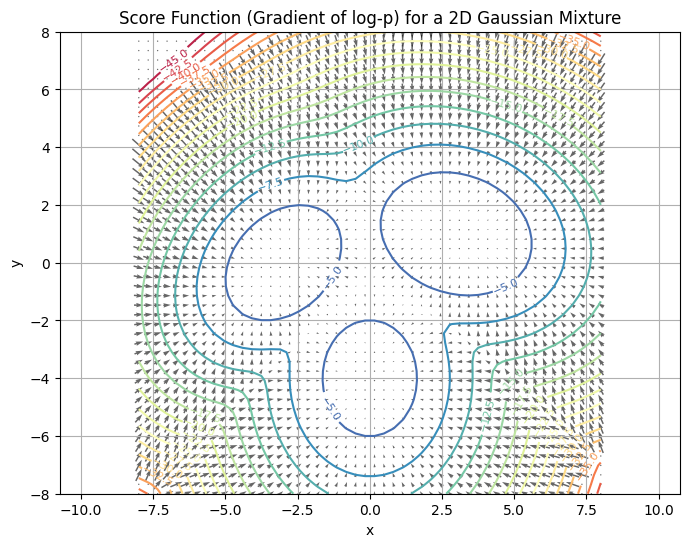

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------
# 1. Define mixture parameters
# ----------------------
# For illustration, let's use a 3-component mixture in 2D:
weights = np.array([0.3, 0.5, 0.2])                # mixture weights must sum to 1
means = [
    np.array([-3.0, 0.0]),
    np.array([ 3.0, 1.0]),
    np.array([ 0.0, -4.0])
]
covariances = [
    np.array([[1.0, 0.3],
              [0.3, 1.0]]),
    np.array([[1.5, -0.2],
              [-0.2, 1.0]]),
    np.array([[1.0, 0.0],
              [0.0, 1.5]])
]

# ----------------------
# 2. Define the probability density and its log-gradient (score)
# ----------------------

def gaussian_pdf(x, mean, cov):
    """
    Evaluate the multivariate Gaussian pdf N(x | mean, cov).
    x is a 2D point (shape (2,) or (2,1)),
    mean is a 2D mean,
    cov is the 2x2 covariance matrix.
    """
    dim = 2
    diff = x - mean
    inv_cov = np.linalg.inv(cov)
    det_cov = np.linalg.det(cov)
    norm_const = 1.0 / (2.0 * np.pi * np.sqrt(det_cov))
    exponent = -0.5 * diff.T @ inv_cov @ diff
    return norm_const * np.exp(exponent)

def mixture_pdf(x, weights, means, covs):
    """
    Mixture PDF = sum_k [ w_k * N_k(x) ].
    """
    pdf_val = 0.0
    for w, m, c in zip(weights, means, covs):
        pdf_val += w * gaussian_pdf(x, m, c)
    return pdf_val

def mixture_score(x, weights, means, covs):
    """
    Returns the score (gradient of log p(x)) for the mixture distribution.
    Score(x) = grad_x log [ sum_k w_k * N_k(x) ].

    In practice:
      Score(x) = (1 / p(x)) * sum_k [ w_k * N_k(x) * grad_x(log N_k(x)) ].
    """
    p_x = mixture_pdf(x, weights, means, covs)
    if p_x < 1e-15:
        # Avoid numerical issues if pdf is extremely small
        return np.array([0.0, 0.0])

    grad_sum = np.zeros(2)
    for w, m, c in zip(weights, means, covs):
        # For a single Gaussian, grad log N(x|m,cov) = -inv(cov)*(x - m).
        inv_cov = np.linalg.inv(c)
        diff = x - m
        grad_log_gauss = - inv_cov @ diff  # shape (2,)

        # Weighted by w_k * N_k(x):
        weight_factor = w * gaussian_pdf(x, m, c)
        grad_sum += weight_factor * grad_log_gauss

    return grad_sum / p_x

def mixture_logpdf(x, weights, means, covs):
    """
    log of the mixture PDF. We do log(sum(...)) carefully.
    """
    # sum of w_k * N_k(x)
    val = mixture_pdf(x, weights, means, covs)
    # add a small epsilon to avoid log(0).
    return np.log(val + 1e-20)

# ----------------------
# 3. Create a grid of points and evaluate the score/log‐density
# ----------------------
grid_size = 50
x_vals = np.linspace(-8, 8, grid_size)
y_vals = np.linspace(-8, 8, grid_size)
X, Y = np.meshgrid(x_vals, y_vals)

# Evaluate log-pdf and the score (U,V) on the grid
log_pdf_vals = np.zeros_like(X)
U = np.zeros_like(X)  # d/dx direction
V = np.zeros_like(X)  # d/dy direction

for i in range(grid_size):
    for j in range(grid_size):
        point = np.array([X[i, j], Y[i, j]])
        log_pdf_vals[i, j] = mixture_logpdf(point, weights, means, covariances)
        grad_val = mixture_score(point, weights, means, covariances)
        U[i, j] = grad_val[0]
        V[i, j] = grad_val[1]

# ----------------------
# 4. Plot the log‐pdf contours and the score vector field
# ----------------------
plt.figure(figsize=(8,6))

# Contour plot of log‐pdf
contour_levels = 20
cs = plt.contour(X, Y, log_pdf_vals, levels=contour_levels, cmap='Spectral')
plt.clabel(cs, inline=1, fontsize=8)

# Plot quiver for the score field
plt.quiver(X, Y, U, V, color='black', alpha=0.6, pivot='mid')

plt.title("Score Function (Gradient of log-p) for a 2D Gaussian Mixture")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.axis('equal')  # so that circles appear circular
plt.show()


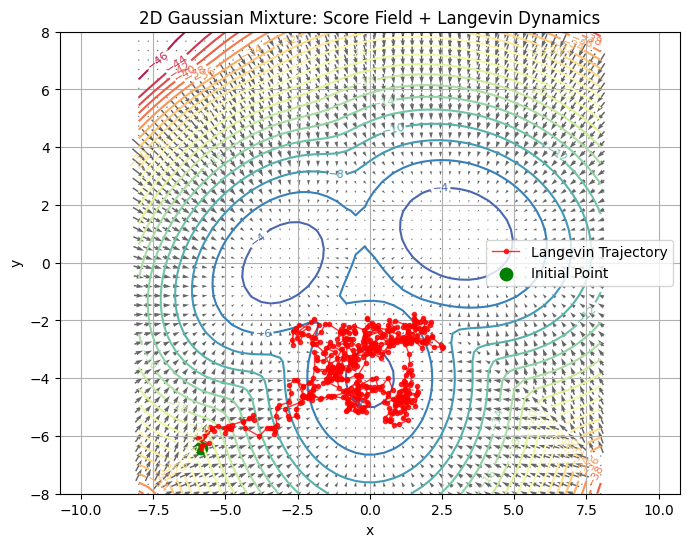

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------
# 1. Define mixture parameters
# ----------------------
weights = np.array([0.3, 0.5, 0.2])
means = [
    np.array([-3.0, 0.0]),
    np.array([ 3.0, 1.0]),
    np.array([ 0.0, -4.0])
]
covariances = [
    np.array([[1.0, 0.3],
              [0.3, 1.0]]),
    np.array([[1.5, -0.2],
              [-0.2, 1.0]]),
    np.array([[1.0, 0.0],
              [0.0, 1.5]])
]

# ----------------------
# 2. Define Gaussian Mixture PDF, log‐PDF, and score
# ----------------------
def gaussian_pdf(x, mean, cov):
    diff = x - mean
    inv_cov = np.linalg.inv(cov)
    det_cov = np.linalg.det(cov)
    norm_const = 1.0 / (2.0 * np.pi * np.sqrt(det_cov))
    exponent = -0.5 * diff.T @ inv_cov @ diff
    return norm_const * np.exp(exponent)

def mixture_pdf(x, weights, means, covs):
    return sum(w * gaussian_pdf(x, m, c)
               for w, m, c in zip(weights, means, covs))

def mixture_score(x, weights, means, covs):
    """
    Gradient of log p(x):
       score(x) = grad_x log [ sum_k w_k * N_k(x) ].
    """
    p_x = mixture_pdf(x, weights, means, covs)
    if p_x < 1e-15:
        # Avoid division by zero
        return np.zeros(2)
    grad_sum = np.zeros(2)
    for w, m, c in zip(weights, means, covs):
        inv_cov = np.linalg.inv(c)
        diff = x - m
        # grad of log N(x|m,c) = -inv_cov * (x - m)
        grad_log_gauss = -inv_cov @ diff
        grad_sum += w * gaussian_pdf(x, m, c) * grad_log_gauss
    return grad_sum / p_x

def mixture_logpdf(x, weights, means, covs):
    return np.log(mixture_pdf(x, weights, means, covs) + 1e-20)

# ----------------------
# 3. Create a grid for visualization (score + log‐pdf)
# ----------------------
grid_size = 50
x_vals = np.linspace(-8, 8, grid_size)
y_vals = np.linspace(-8, 8, grid_size)
X, Y = np.meshgrid(x_vals, y_vals)

log_pdf_vals = np.zeros_like(X)
U = np.zeros_like(X)
V = np.zeros_like(X)

for i in range(grid_size):
    for j in range(grid_size):
        point = np.array([X[i, j], Y[i, j]])
        log_pdf_vals[i, j] = mixture_logpdf(point, weights, means, covariances)
        grad_val = mixture_score(point, weights, means, covariances)
        U[i, j] = grad_val[0]
        V[i, j] = grad_val[1]

# ----------------------
# 4. Langevin dynamics simulation
# ----------------------
def langevin_dynamics(x0, score_fn, step_size=0.01, n_steps=1000):
    """
    x0: initial position (2D array).
    score_fn: function that returns gradient log p(x).
    step_size: the step-size parameter eta in the Langevin update.
    n_steps: number of Langevin iterations.

    Returns:
        traj (np.ndarray): array of shape (n_steps+1, 2) containing the
                           positions at each time step.
    """
    traj = [x0.copy()]
    x = x0.copy()

    for _ in range(n_steps):
        # score = gradient of log p(x)
        grad_logp = score_fn(x)
        # Langevin update:
        #   x_{t+1} = x_t + step_size * grad_logp + sqrt(2*step_size)*noise
        noise = np.random.randn(2)
        x = x + step_size * grad_logp + np.sqrt(2 * step_size) * noise
        traj.append(x.copy())

    return np.array(traj)

# Random initial point in the field
x0 = np.random.uniform(low=-8, high=8, size=2)

# Run the Langevin simulation
trajectory = langevin_dynamics(x0,
                               lambda x: mixture_score(x, weights, means, covariances),
                               step_size=0.02,
                               n_steps=500)

# ----------------------
# 5. Plot everything
# ----------------------
plt.figure(figsize=(8,6))

# Contour plot of log‐pdf
cs = plt.contour(X, Y, log_pdf_vals, levels=25, cmap='Spectral')
plt.clabel(cs, inline=1, fontsize=8)

# Quiver for the score field
plt.quiver(X, Y, U, V, color='black', alpha=0.6, pivot='mid')

# Plot the Langevin trajectory
plt.plot(trajectory[:, 0], trajectory[:, 1], '-o', color='red', markersize=3,
         linewidth=1, alpha=0.8, label="Langevin Trajectory")

plt.scatter([trajectory[0,0]], [trajectory[0,1]], color='green', s=80,
            label="Initial Point")

plt.title("2D Gaussian Mixture: Score Field + Langevin Dynamics")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.show()
